In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio as io

In [58]:
def lowpass_filter(shape, d0=160, n=4, u_k=0, v_k=0):

	P, Q = shape
	# Initialize filter with zeros
	H = np.zeros((P, Q))

	# Traverse through filter
	for u in range(0, P):
		for v in range(0, Q):
			# Get euclidean distance from point D(u,v) to the center
			D_uv = np.sqrt((u - P/2 + u_k)**2 + (v - Q/2 + v_k)**2)

			# Define lowpass transfer funtion according to filter type

			H[u, v] = 1/(1 + (D_uv/d0)**(2*n))

			

	return H

In [59]:
def highpass_filter(shape, d0=160, n=4, u_k=0, v_k=0):
	# Inverse of lowpass
	H = 1.0 - lowpass_filter(shape, d0, n, u_k, v_k)
	return H

In [60]:
def notch_reject_filter(shape, d0=160, n=4, u_k=0, v_k=0):
	# Form product of highpass filters at position (-u_k, -v_k) and (u_k, v_k)
	H = highpass_filter(shape, d0, n, -u_k, -v_k) * highpass_filter(shape, d0, n, u_k, v_k)
	return H

In [61]:
def notch_pass_filter(shape, d0=160, n=4, u_k=0, v_k=0):
	# Inverse of notch reject
	H = 1.0 - notch_reject_filter(shape, d0, n, u_k, v_k)
	return H

In [66]:
def bandreject_filter(shape, d0=160, w=20, n=4):

	P, Q = shape
	# Initialize filter with ones
	H = np.ones((P, Q))

	# Traverse through filter
	for u in range(0, P):
		for v in range(0, Q):
			# Get euclidean distance from point D(u,v) to the center
			D_uv = np.sqrt((u - (P/2))**2 + (v - (Q/2))**2)

			# Define bandreject transfer funtion for each filter type

			if D_uv == d0: # To avoid dividing by zero
				H[u, v] = 0
			else:
				H[u, v] = 1/(1 + ((D_uv*w)/(D_uv**2 - d0**2))**(2*n))

	return H

In [62]:
def filter_image_freq(img, d0=160, w=20, n=4, u_k=0, v_k=0):

	# Get padding parameters
	M, N = img.shape
	P = 2*M
	Q = 2*N

	# Take the fourier transform of the image, with padding to shape P X Q
	F = np.fft.fft2(img, s=(P,Q))

	# Shift the low frequencies to the center.
	F = np.fft.fftshift(F)

	# Get power spectrum of the image
	pow_spec = np.abs(F)**2


# 	H = notch_reject_filter(F.shape, d0, n, u_k, v_k)
    H = bandreject_filter(F.shape, d0, w, n)
	# Form product of image with filter
	G = F * H

	# Shift frequencies back
	G = np.fft.ifftshift(G)

	# Inverse fourier transform to get output image in spatial domain
	G = np.fft.ifft2(G)

	# Get real values
	G = np.abs(G)

	# Extract M x N image from top left quadrant
	G = G[0:M, 0:N]

	# Return output image, the filter used and the power spectrum of input image
	return G, np.abs(H), np.log(pow_spec)

(array([[196.04220892, 156.87450584, 149.42171116, ..., 126.48649014,
        105.4527555 ,  53.60867026],
       [173.69954433,  75.66179546,  41.16117669, ..., 129.5517979 ,
         58.6539947 ,  63.31343605],
       [186.28865238, 106.21533813,  84.54586129, ...,  64.5883345 ,
         62.15130285,  84.10693276],
       ...,
       [117.80434241, 140.83278339,  93.77089651, ..., 104.29724829,
        157.21284918, 192.36656322],
       [114.22622742,  78.15383674,  97.28351691, ..., 159.38535908,
        147.51120713, 208.08910069],
       [120.9722065 ,  98.8707123 , 128.13116514, ..., 191.46873573,
        153.10643125, 255.97485479]]), array([[0.99999996, 0.99999996, 0.99999996, ..., 0.99999998, 0.99999998,
        0.99999998],
       [0.99999996, 0.99999996, 0.99999996, ..., 0.99999998, 0.99999998,
        0.99999998],
       [0.99999996, 0.99999996, 0.99999996, ..., 0.99999998, 0.99999998,
        0.99999998],
       ...,
       [0.99999998, 0.99999998, 0.99999998, ..., 0.9999

NameError: name 'mp' is not defined

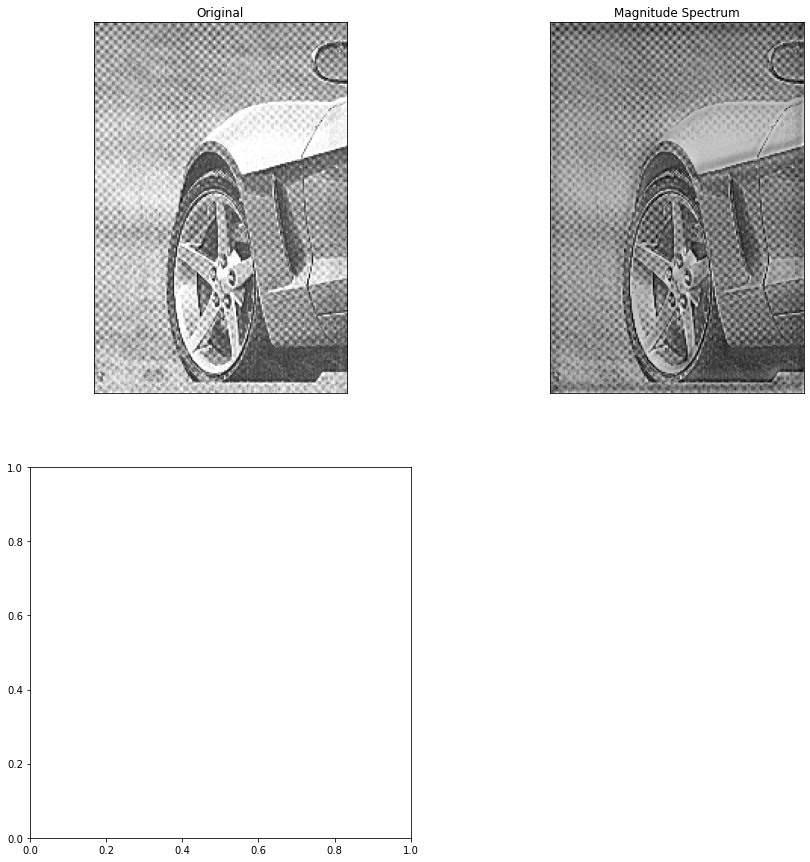

In [69]:
img2 = cv2.imread('Img-1.tif', 0)
lema=filter_image_freq(img2,30,20,4,30,27)
print(lema)

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
plt.subplot(2,2,1),plt.imshow(img2,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])


plt.subplot(2,2,2),plt.imshow(lema[0],cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

plt.subplot(2,2,3),plt.imshow(mp.log(lema[2])*np.abs(lema[1]), "gray") 
plt.title("Butterworth Notch Reject Filter"),plt.xticks([]), plt.yticks([])

plt.subplot(2,2,4),plt.imshow(lema[2],cmap="gray") 
plt.title("Filtered Image"),plt.xticks([]), plt.yticks([])


plt.show()